# **Sentiment Analysis using RNN**

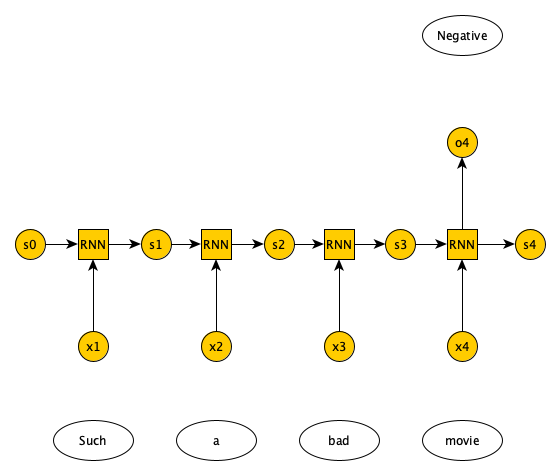

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# read a file
gdrive_path = '/content/drive/MyDrive/mydata/'

**Data**

In [4]:
#read the reviews
import pandas as pd
#df = pd.read_excel(f"{gdrive_path}IMDB_Dataset_label.csv")

data = pd.read_csv(f"{gdrive_path}IMDB_Dataset_label.csv", error_bad_lines=False)
data.sample(n=10)

<ipython-input-4-c76a2d932320>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f"{gdrive_path}IMDB_Dataset_label.csv", error_bad_lines=False)


,Unnamed: 0,review,sentiment,label
28488,28488,"Yes, this movie is bad. What's worse is that i...",negative,0
41277,41277,i thought this movie was really really great! ...,positive,1
38109,38109,"When I was 10 (currently 14), I vowed to never...",positive,1
28364,28364,This BBC version of an Agatha Christie book sh...,positive,1
33367,33367,"""Hey everybody! I've got an idea, we found thi...",negative,0
15516,15516,this isn't 'Bonnie and Clyde' or 'Thelma and L...,positive,1
26646,26646,I just want to say that Chris Diamantopoulos's...,positive,1
42597,42597,"I'm a big fan of the ""Vacation"" franchise, and...",negative,0
29314,29314,"Well, I have to say, this movie was probably t...",positive,1
44673,44673,"First, I should mention that I really enjoyed ...",negative,0


In [5]:
data.groupby('label').describe()

Unnamed: 0                                                              \
           count         mean           std  min      25%      50%       75%   
label                                                                          
0        25000.0  24964.07768  14461.920812  3.0  12403.5  24940.0  37482.50   
1        25000.0  25034.92232  14406.028970  0.0  12577.0  25039.0  37524.25   

                
           max  
label           
0      49999.0  
1      49995.0

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
%matplotlib inline

In [7]:
data.label.value_counts()

1    25000
0    25000
Name: label, dtype: int64

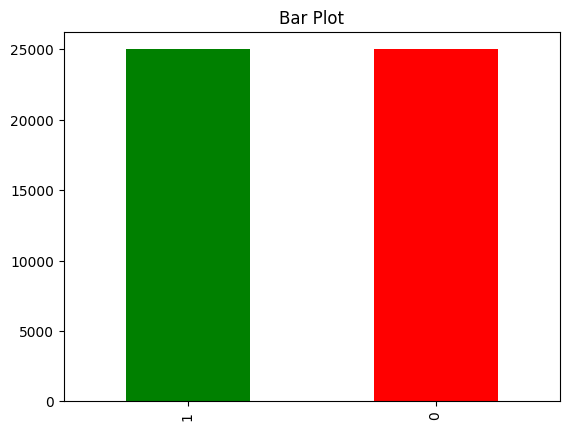

In [8]:
count_Class=pd.value_counts(data["label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show()

**Wordcloud Analysis**

In [9]:
neg_data  = data[data['label'] == 0].copy()
pos_data = data[data['label'] == 1].copy()

In [12]:
import wordcloud
from wordcloud import WordCloud
def show_wordcloud(df, title):
    text = ' '.join(df['review'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

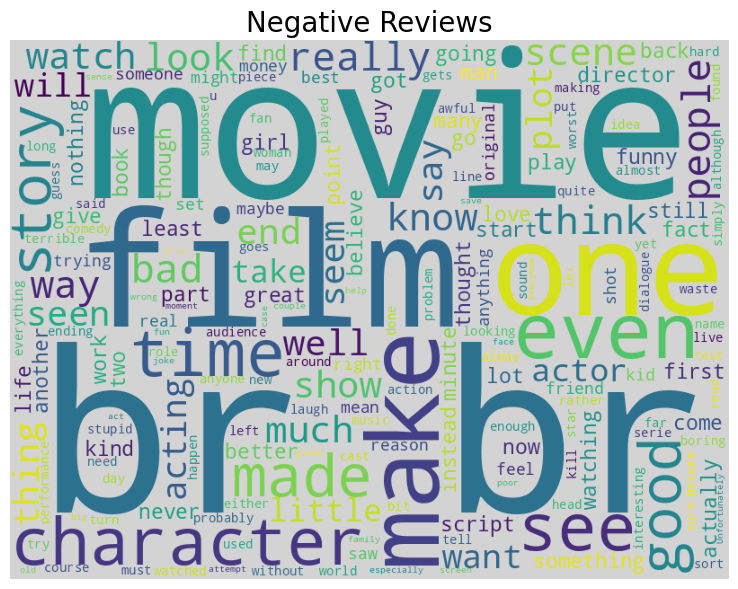

In [13]:
show_wordcloud(neg_data, "Negative Reviews")

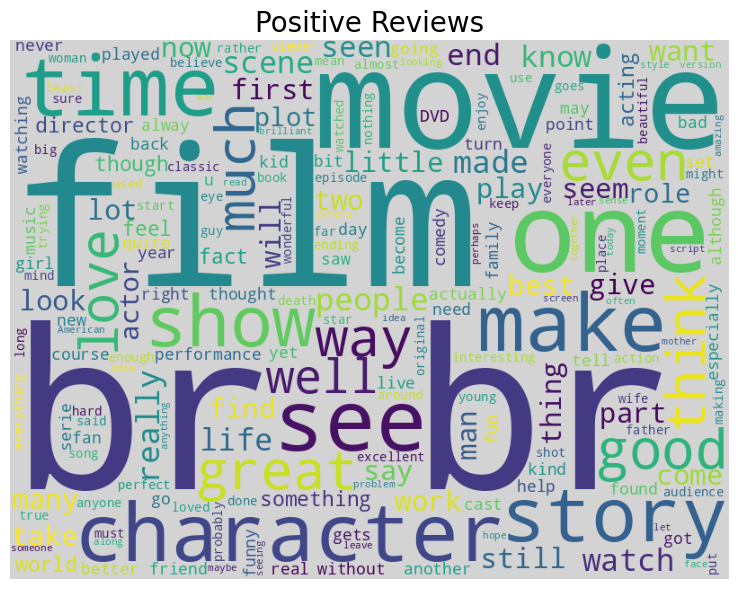

In [14]:
show_wordcloud(pos_data, "Positive Reviews")

In [15]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

**Training and Testing Data**

In [16]:
X = data['review'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
t = Tokenizer()
t.fit_on_texts(X_train)

In [18]:
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[197, 48, 10, 801, 2160, 534, 302, 1, 107, 1907, 2038, 4324, 6550, 2, 815, 4844, 12, 22579, 1, 13693, 227, 1, 6190, 79, 782, 53, 52, 22, 101, 4, 1, 27, 2009, 102, 36, 25, 34, 119, 1130, 12, 9, 6, 2366, 1190, 5, 454, 48, 552, 5, 92, 33, 23, 39, 916, 400, 29670, 15, 1, 166, 5, 2993, 24, 38443, 4359, 20, 3, 2945, 12, 45, 75, 221, 73, 126, 8, 81, 3155, 195, 20, 239, 2, 1, 447, 7, 7, 10, 205, 4982, 144, 21, 63, 27, 15, 14644, 74, 365, 302, 3, 19, 18, 9, 205, 26, 307, 12, 65051, 43365, 14, 1, 14998, 10161, 115, 439, 2, 50893, 50894, 14, 1, 1704, 11316, 615, 70, 424, 381, 10, 89, 118, 48, 112, 370, 33, 11929, 35, 18, 43, 10, 13, 92, 485, 6830, 15, 3, 364, 12380, 1182, 24863, 61, 65052, 65053, 8, 1, 470, 216, 1014, 5, 4160, 8, 3, 174, 4, 34, 440, 697, 623, 12, 3748, 237, 111, 848, 35, 170, 30, 219, 197, 1, 428, 367, 55, 3765, 3, 278, 10620, 7, 7, 157, 1707, 187, 6, 1, 11696, 11505, 727, 1935, 1, 1200, 4, 2946, 11506, 3749, 1828, 2, 34820, 147, 144, 3, 228, 4, 3, 207, 323, 2, 144, 1083, 16, 88

In [19]:
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[   35     1  3797 ...   205   351  3856]
 [   75  1722    18 ...    89   103     9]
 [   12   395    87 ...     2   710    62]
 ...
 [  517    54    50 ...  1641     2   603]
 [   20   373   266 ...   125  7285 16293]
 [  328     1   112 ...    70    73  2062]]


**RNN Model**

In [20]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(SimpleRNN(24, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             2694744   
                                                                 
 simple_rnn (SimpleRNN)      (None, 24)                1176      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2,695,945
Trainable params: 2,695,945
Non-trainable params: 0
_________________________________________________________________
None


**Model Training**

In [21]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=100,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/100
1250/1250 [==============================] - 28s 22ms/step - loss: 0.5776 - accuracy: 0.6827 - val_loss: 0.5420 - val_accuracy: 0.7179
Epoch 2/100
1250/1250 [==============================] - 25s 20ms/step - loss: 0.5001 - accuracy: 0.7521 - val_loss: 0.5349 - val_accuracy: 0.7240
Epoch 3/100
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4577 - accuracy: 0.7839 - val_loss: 0.5451 - val_accuracy: 0.7206
Epoch 4/100
1250/1250 [==============================] - 33s 26ms/step - loss: 0.4146 - accuracy: 0.8109 - val_loss: 0.5754 - val_accuracy: 0.7110
Epoch 5/100
1250/1250 [==============================] - 36s 29ms/step - loss: 0.3757 - accuracy: 0.8362 - val_loss: 0.5993 - val_accuracy: 0.7016
Epoch 6/100
1250/1250 [==============================] - 29s 23ms/step - loss: 0.3421 - accuracy: 0.8527 - val_loss: 0.6287 - val_accuracy: 0.7026
Epoch 7/100
1250/1250 [==============================] - 31s 25ms/step - loss: 0.3144 - accuracy: 0.8669 - val_loss: 0

**Confusion Matrix**

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [23]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

313/313 [==============================] - 2s 3ms/step


In [24]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      4961
           1       0.70      0.68      0.69      5039

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

Accuracy : 0.6915


0.6915

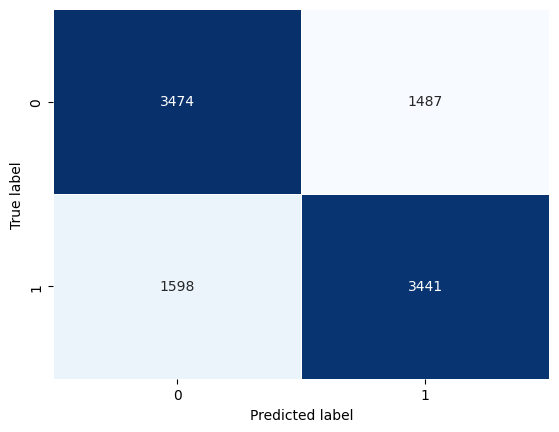

In [25]:
plot_confusion_matrix(y_test, preds)

**Save Models**

In [26]:
model.save(f"{gdrive_path}sentiment_simplernn_model_v1.sav")

In [27]:
import pickle
with open(f'{gdrive_path}sentiment_simplernn_tokenizer_v1.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

In [28]:
import tensorflow as tf

s_model = tf.keras.models.load_model(f"{gdrive_path}sentiment_simplernn_model_v1.sav")
with open(f'{gdrive_path}sentiment_simplernn_tokenizer_v1.pkl', 'rb') as input:
    tokenizer = pickle.load(input)

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

review = ["I think this is a very great movie."]
#sms = ["hello! how are you? im visiting mom next week"]
review_proc = t.texts_to_sequences(review)
review_proc = pad_sequences(review_proc, maxlen=max_length, padding='post')
pred = (model.predict(review_proc)>0.5).astype("int32").item()
print(pred)

1/1 [==============================] - 0s 23ms/step
1
